In [59]:
import numpy as np
import os
import trimesh
from trimesh.sample import sample_surface_sphere
from trimesh.ray.ray_pyembree import RayMeshIntersector
from shapely.geometry import LineString
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
from open3d import *
import math
%matplotlib inline

In [60]:
DATA_DIR = '../../data/Experiment'
# synsetId = '02691156'
# modelId = 'afc2efb530e899634d4cb1c2a5e48b7a'

# MODEL_DIR = os.path.join(DATA_DIR, synsetId, modelId, 'models')
# STATS = os.path.join(MODEL_DIR, 'model_normalized.json')
# MESH = os.path.join(MODEL_DIR, 'model_normalized.obj')
# MATERIALS = os.path.join(MODEL_DIR, 'model_normalized.mtl')
# FULL_VOXELS = os.path.join(MODEL_DIR, 'model_normalized.solid.binvox')
# SURF_VOXELS = os.path.join(MODEL_DIR, 'model_normalized.surface.binvox')
MESH = os.path.join(DATA_DIR, 'arm_all_simple.obj')

In [61]:
mesh = trimesh.load_mesh(MESH)
mesh.show()

In [62]:
mesh.is_watertight

True

In [63]:
mesh.bounds

array([[-63.56352905, -54.08965532, -57.73525595],
       [ 63.52750964,  97.22061059,  57.78779674]])

In [64]:
class MeshSampler:
    def __init__(self, mesh, check_faces=False):
        self.mesh = mesh
        self.sphere_points = trimesh.sample.sample_surface(mesh.bounding_sphere, count=1000)[0]*2
        self.correct_faces = {i:0 for i in range(len(mesh.faces))}
        self.ray_mesh = RayMeshIntersector(geometry=mesh)
        self.faces_centroids = self.mesh.triangles.mean(axis=1)
        self.correct_points = np.array([])
        if check_faces:
            self.compute_visible_faces()
        else:
            self.correct_faces = {i:1 for i in range(len(mesh.faces))}
    
    def visible_faces(self):
        return self.correct_faces
        
    def compute_visible_faces(self):
        for i, face in enumerate(tqdm(self.mesh.triangles)):
            for point in face:
                ray_directions = -(self.sphere_points - point)
                faces_hit = self.ray_mesh.intersects_first(self.sphere_points, ray_directions)
                if i in faces_hit:
                    self.correct_faces[i] = 1
        return self.correct_faces
    
    def sample_points(self, n_points=10000):
        points = trimesh.sample.sample_surface(self.mesh, count=n_points)
        correct_points = []
        normals_for_points = []
        for i, point in enumerate(tqdm(points[0])):
            if self.correct_faces[points[1][i]] == 1:
                correct_points += [point]
                normals_for_points += [self.mesh.face_normals[points[1][i]]]
        self.correct_points = np.array(correct_points)
        self.normals_for_points = np.array(normals_for_points)
        return self.correct_points
    
    def compute_sdf(self, sigma=0.0025):
        noise = np.random.normal(0, sigma, self.correct_points.shape)
        noisy_points = self.correct_points + noise
        sdf = self.mesh.nearest.signed_distance(noisy_points)
        correct_mesh_points = []
        correct_sdf = []
        correct_normals = []
        for i, distance in enumerate(sdf):
            if math.isnan(distance):
                continue
            else:
                correct_mesh_points += [noisy_points[i]]
                correct_sdf += [sdf[i]]
                correct_normals += [self.normals_for_points[i]]
        return np.array(correct_mesh_points), np.array(correct_sdf), np.array(correct_normals)

In [65]:
a = MeshSampler(mesh, check_faces=False)

In [66]:
print('All faces:', len(mesh.faces))
print('Visible faces:', len(a.visible_faces()))
print('Ratio of invisible faces:', (len(mesh.faces)-len(a.visible_faces()))/len(mesh.faces))

All faces: 7746
Visible faces: 7746
Ratio of invisible faces: 0.0


In [67]:
points = a.sample_points(250000)

<ipython-input-64-312f1c59bc08>:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, point in enumerate(tqdm(points[0])):


In [68]:
points = np.array(points)

In [69]:
len(points)

250000

In [70]:
points, sdf, normals = a.compute_sdf(10)

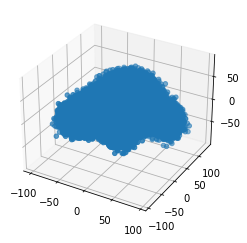

In [71]:
trimesh.points.plot_points(points)

In [73]:
np.save(os.path.join(DATA_DIR, 'points.npy'), np.array(points) / np.array(100.0))

In [74]:
np.save(os.path.join(DATA_DIR, 'sdf.npy'), np.array(sdf))

In [75]:
np.save(os.path.join(DATA_DIR, 'normals.npy'), np.array(normals))